# IMPORTS

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
!unzip /drive/MyDrive/data/data.zip -d ../


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ../data/train/Slovenia_MB-ZG-900.jpg  
  inflating: ../data/train/Slovenia_MB-ZR-247.jpg  
  inflating: ../data/train/Slovenia_MS-AH-002.jpg  
  inflating: ../data/train/Slovenia_MS-AHM012.jpg  
  inflating: ../data/train/Slovenia_MS-BENO.jpg  
  inflating: ../data/train/Slovenia_MS-EURO.jpg  
  inflating: ../data/train/Slovenia_MS-FA-021.jpg  
  inflating: ../data/train/Slovenia_MS-FZ-420.jpg  
  inflating: ../data/train/Slovenia_MS-HI-489.jpg  
  inflating: ../data/train/Slovenia_MS-MURA.jpg  
  inflating: ../data/train/Slovenia_MS-VR-877.jpg  
  inflating: ../data/train/Slovenia_MS-VS-262.jpg  
  inflating: ../data/train/Slovenia_MS-VU-327.jpg  
  inflating: ../data/train/Slovenia_NM-AZ-913.jpg  
  inflating: ../data/train/Slovenia_NM-BG-734.jpg  
  inflating: ../data/train/Slovenia_NM-CL-737.jpg  
  inflating: ../data/train/Slovenia_NM-DB-665.jpg  
  inflating: ../data/train/Slovenia_NM-DZ-53

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 20.9 MB/s eta 0:00:00


In [ ]:
from os import path, listdir
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import models, transforms
import torch.nn as nn
from torch.nn import Module, Sequential, Conv2d, ReLU, MaxPool2d, LSTM, Linear
from torch.optim import Adam
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch.nn.functional as F
import glob
import numpy as np
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 256
PLATE_SIZE = 12

# PreProcessing

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.2 MB/s eta 0:00:00


## Fonctions de preprocess

Dans cette étape, nous prétraitons les images, c'est-à-dire que nous extrayons les plaques d'immatriculation grâce aux détections (fichier detections.csv, qui contient les coordonnées des plaques extraites par le modèle YOLO). Ensuite, nous redimensionnons les plaques afin qu'elles aient toutes la même taille.

In [ ]:
import os
import pandas as pd
import cv2
import torch
from unidecode import unidecode
from tqdm import tqdm
from torchvision import transforms
from concurrent.futures import ThreadPoolExecutor

def process_image(image_path, row, output_size):
    try:
        # Charger et découper l'image
        image = cv2.imread(image_path)
        if image is None:
            return None, None

        x_min, x_max, y_min, y_max = map(int, [row["X_min"], row["X_max"], row["Y_min"], row["Y_max"]])
        cropped = image[y_min:y_max, x_min:x_max]

        # Redimensionner avec transformations Torch
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(output_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x / 255.0 + 1e-3)
        ])

        processed_plate = transform(cropped)

        # Extraire et transformer l'étiquette
        plate = row["Plaque"]
        label = unidecode(plate).upper()

        return processed_plate, label
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

def extract_plates_and_labels(images_dir, csv_path, output_size):
    # Précharger les données du CSV
    detections = pd.read_csv(csv_path).set_index("Filename")

    plates, labels = [], []

    # Filtrer les fichiers image
    image_paths = [
        os.path.join(images_dir, img_name)
        for img_name in os.listdir(images_dir)
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    # Créer un dictionnaire des informations pour un accès plus rapide
    detections_dict = detections.to_dict(orient='index')

    def process_image_batch(image_path):
        img_name = os.path.basename(image_path)
        if img_name in detections_dict:
            row = detections_dict[img_name]
            return process_image(image_path, row, output_size)
        return None, None

    # Utiliser un ThreadPoolExecutor pour paralléliser le traitement des images
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_image_batch, image_paths), total=len(image_paths)))

    # Ajouter les résultats dans les listes
    for processed_plate, label in results:
        if processed_plate is not None and label is not None:
            plates.append(processed_plate)

            labels.append(label)

    return plates, labels


In [ ]:
def encode_labels(labels, char_to_idx, padding_value=0, size=50):
    encoded_labels = [[char_to_idx[char] for char in label] for label in labels]

    # Pad each label to the max length
    for i in range(len(encoded_labels)):
        padding = [padding_value] * (size - len(encoded_labels[i]))
        encoded_labels[i].extend(padding)

    # Convert each list into a tensor
    tensor_labels = [torch.tensor(label, dtype=torch.long) for label in encoded_labels]

    return tensor_labels


# Dictionnaires pour encoder
char_to_idx = {
            '': 0,
            **{chr(i): idx for idx, i in enumerate(range(ord('A'), ord('Z') + 1), start=1)},
            **{str(i): idx + 26 for idx, i in enumerate(range(10))},
            '-': 37,
            ' ': 38,
            '.': 39
        }
idx_to_char = {v: k for k, v in char_to_idx.items()}

In [ ]:
class PlateDataset(Dataset):
    def __init__(self, images,labels):

        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        Fetch a single sample (image and label).

        Args:
            idx (int): Index of the sample.

        Returns:
            Tuple[torch.Tensor, str]: The processed image tensor and its label.
        """
        return (self.images[idx],self.labels[idx])

In [ ]:
csv_path = "/data/detections.csv"

X_train,Y_train = extract_plates_and_labels("/data/train",csv_path,(IMAGE_HEIGHT,IMAGE_WIDTH))
X_val,Y_val =  extract_plates_and_labels("/data/val",csv_path,(IMAGE_HEIGHT,IMAGE_WIDTH))
X_test,Y_test =  extract_plates_and_labels("/data/test",csv_path,(IMAGE_HEIGHT,IMAGE_WIDTH))

Y_train_encoded = encode_labels(Y_train,char_to_idx,0,PLATE_SIZE)
Y_val_encoded = encode_labels(Y_val,char_to_idx,0,PLATE_SIZE)
Y_test_encoded = encode_labels(Y_test,char_to_idx,0,PLATE_SIZE)



100%|██████████| 2927/2927 [00:36<00:00, 80.40it/s]


In [ ]:
print(f"NB train samples : {len(Y_train_encoded)}, X_train shape : {X_train[0].shape}")
print(f"NB val samples : {len(Y_val_encoded)}, X_val shape : {X_val[0].shape}")
print(f"NB test samples : {len(Y_test_encoded)}, X_test shape : {X_test[0].shape}")

NB train samples : 13294, X_train shape : torch.Size([3, 128, 256])
NB val samples : 2926, X_val shape : torch.Size([3, 128, 256])
NB test samples : 2927, X_test shape : torch.Size([3, 128, 256])


# Model

Model : actuellement un resnet50 pour extraire les features puis un transformer pour créer les séquences

In [63]:
import torch
import torch.nn as nn
import torchvision.models as models

class CRNNWithLSTM(nn.Module):
    def __init__(self, num_classes, plate_size, image_height, image_width,
                 lstm_hidden_size=64, num_layers=2, dropout_rate=0.2):
        super(CRNNWithLSTM, self).__init__()
        self.plate_size = plate_size

        # EfficientNet-B0 as feature extractor
        efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(efficientnet.children())[:-2])  # Remove classifier layers

        OUTPUT_FEATURES = 1280  # EfficientNet-B0 output channels

        # 1x1 Conv to reduce channel dimensions if needed
        self.conv1x1 = nn.Conv2d(OUTPUT_FEATURES, 1020, kernel_size=1)

        # Compute convolutional output size dynamically
        def calculate_conv_output_size(height, width):
            dummy_input = torch.zeros(1, 3, height, width)
            with torch.no_grad():
                output = self.features(dummy_input)
            return output.size(2), output.size(3)

        conv_h, conv_w = calculate_conv_output_size(image_height, image_width)
        self.feature_size = conv_h * conv_w * 1020  # Adjusted based on EfficientNet output

        # LSTM layer
        self.lstm = nn.LSTM(input_size=self.feature_size // plate_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=num_layers,
                            dropout=dropout_rate,
                            batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        # Extract features with EfficientNet
        x = self.features(x)  # Shape: (batch_size, 1280, conv_h, conv_w)
        x = self.conv1x1(x)   # Shape: (batch_size, 1024, conv_h, conv_w)

        # Reshape and prepare for LSTM
        x = x.permute(0, 2, 3, 1).contiguous()  # Shape: (batch_size, conv_h, conv_w, 1024)
        x = x.view(batch_size, self.plate_size, -1)  # Shape: (batch_size, plate_size, feature_size // plate_size)

        # LSTM processing
        x, _ = self.lstm(x)  # Shape: (batch_size, plate_size, lstm_hidden_size)

        # Predict classes
        outputs = self.fc(x)  # Shape: (batch_size, plate_size, num_classes)
        return outputs


In [34]:
BATCH_SIZE = 16

# Créer le dataset et dataloader
dataset_train = PlateDataset(X_train,Y_train_encoded)
dataset_val = PlateDataset(X_val,Y_val_encoded)
dataset_test = PlateDataset(X_test,Y_test_encoded)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [64]:
model = CRNNWithLSTM(dropout_rate=0.3,num_classes=len(idx_to_char)+1,plate_size=PLATE_SIZE,image_height=IMAGE_HEIGHT,image_width=IMAGE_WIDTH)

In [49]:
import gc

gc.collect()



20

# Train Model

Using device: cuda


Epoch 1/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 63.04it/s]


Epoch [1/100], Train Loss: 2.4621, Validation Loss: 2.2096
Validation loss improved. Model saved.


Epoch 2/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 63.91it/s]


Epoch [2/100], Train Loss: 2.0927, Validation Loss: 1.9250
Validation loss improved. Model saved.


Epoch 3/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 61.21it/s]


Epoch [3/100], Train Loss: 1.8298, Validation Loss: 1.7195
Validation loss improved. Model saved.


Epoch 4/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 64.44it/s]


Epoch [4/100], Train Loss: 1.6786, Validation Loss: 1.6274
Validation loss improved. Model saved.


Epoch 5/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 60.83it/s]


Epoch [5/100], Train Loss: 1.5925, Validation Loss: 1.5656
Validation loss improved. Model saved.


Epoch 6/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 57.18it/s]


Epoch [6/100], Train Loss: 1.5281, Validation Loss: 1.5094
Validation loss improved. Model saved.


Epoch 7/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 56.96it/s]


Epoch [7/100], Train Loss: 1.4627, Validation Loss: 1.4469
Validation loss improved. Model saved.


Epoch 8/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 63.42it/s]


Epoch [8/100], Train Loss: 1.3929, Validation Loss: 1.3798
Validation loss improved. Model saved.


Epoch 9/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 63.35it/s]


Epoch [9/100], Train Loss: 1.3228, Validation Loss: 1.3081
Validation loss improved. Model saved.


Epoch 10/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 61.77it/s]


Epoch [10/100], Train Loss: 1.2499, Validation Loss: 1.2359
Validation loss improved. Model saved.


Epoch 11/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 62.58it/s]


Epoch [11/100], Train Loss: 1.1698, Validation Loss: 1.1605
Validation loss improved. Model saved.


Epoch 12/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 59.71it/s]


Epoch [12/100], Train Loss: 1.0871, Validation Loss: 1.0788
Validation loss improved. Model saved.


Epoch 13/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 51.93it/s]


Epoch [13/100], Train Loss: 1.0013, Validation Loss: 1.0035
Validation loss improved. Model saved.


Epoch 14/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 57.58it/s]


Epoch [14/100], Train Loss: 0.9175, Validation Loss: 0.9287
Validation loss improved. Model saved.


Epoch 15/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 62.72it/s]


Epoch [15/100], Train Loss: 0.8431, Validation Loss: 0.8683
Validation loss improved. Model saved.


Epoch 16/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 62.18it/s]


Epoch [16/100], Train Loss: 0.7740, Validation Loss: 0.8112
Validation loss improved. Model saved.


Epoch 17/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 61.12it/s]


Epoch [17/100], Train Loss: 0.7097, Validation Loss: 0.7565
Validation loss improved. Model saved.


Epoch 18/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 50.20it/s]


Epoch [18/100], Train Loss: 0.6481, Validation Loss: 0.7223
Validation loss improved. Model saved.


Epoch 19/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 62.25it/s]


Epoch [19/100], Train Loss: 0.5914, Validation Loss: 0.6730
Validation loss improved. Model saved.


Epoch 20/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 61.69it/s]


Epoch [20/100], Train Loss: 0.5446, Validation Loss: 0.6396
Validation loss improved. Model saved.


Epoch 21/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 61.86it/s]


Epoch [21/100], Train Loss: 0.5011, Validation Loss: 0.6109
Validation loss improved. Model saved.


Epoch 22/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 59.99it/s]


Epoch [22/100], Train Loss: 0.4590, Validation Loss: 0.5863
Validation loss improved. Model saved.


Epoch 23/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 51.78it/s]


Epoch [23/100], Train Loss: 0.4237, Validation Loss: 0.5622
Validation loss improved. Model saved.


Epoch 24/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 62.65it/s]


Epoch [24/100], Train Loss: 0.3892, Validation Loss: 0.5408
Validation loss improved. Model saved.


Epoch 25/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 60.66it/s]


Epoch [25/100], Train Loss: 0.3599, Validation Loss: 0.5276
Validation loss improved. Model saved.


Epoch 26/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 61.95it/s]


Epoch [26/100], Train Loss: 0.3314, Validation Loss: 0.5056
Validation loss improved. Model saved.


Epoch 27/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 57.92it/s]


Epoch [27/100], Train Loss: 0.3095, Validation Loss: 0.4956
Validation loss improved. Model saved.


Epoch 28/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 52.18it/s]


Epoch [28/100], Train Loss: 0.2809, Validation Loss: 0.4923
Validation loss improved. Model saved.


Epoch 29/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 61.65it/s]


Epoch [29/100], Train Loss: 0.2622, Validation Loss: 0.4875
Validation loss improved. Model saved.


Epoch 30/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 64.51it/s]


Epoch [30/100], Train Loss: 0.2413, Validation Loss: 0.4715
Validation loss improved. Model saved.


Epoch 31/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 61.54it/s]


Epoch [31/100], Train Loss: 0.2262, Validation Loss: 0.4672
Validation loss improved. Model saved.


Epoch 32/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 62.98it/s]


Epoch [32/100], Train Loss: 0.2120, Validation Loss: 0.4514
Validation loss improved. Model saved.


Epoch 33/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 63.56it/s]


Epoch [33/100], Train Loss: 0.1960, Validation Loss: 0.4454
Validation loss improved. Model saved.


Epoch 34/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 58.87it/s]


Epoch [34/100], Train Loss: 0.1833, Validation Loss: 0.4498
No improvement in validation loss. Patience: 1/5


Epoch 35/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 53.90it/s]


Epoch [35/100], Train Loss: 0.1720, Validation Loss: 0.4358
Validation loss improved. Model saved.


Epoch 36/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 57.24it/s]


Epoch [36/100], Train Loss: 0.1609, Validation Loss: 0.4376
No improvement in validation loss. Patience: 1/5


Epoch 37/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 59.93it/s]


Epoch [37/100], Train Loss: 0.1494, Validation Loss: 0.4283
Validation loss improved. Model saved.


Epoch 38/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 61.87it/s]


Epoch [38/100], Train Loss: 0.1403, Validation Loss: 0.4287
No improvement in validation loss. Patience: 1/5


Epoch 39/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 61.89it/s]


Epoch [39/100], Train Loss: 0.1300, Validation Loss: 0.4226
Validation loss improved. Model saved.


Epoch 40/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 59.92it/s]


Epoch [40/100], Train Loss: 0.1244, Validation Loss: 0.4201
Validation loss improved. Model saved.


Epoch 41/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 49.89it/s]


Epoch [41/100], Train Loss: 0.1194, Validation Loss: 0.4263
No improvement in validation loss. Patience: 1/5


Epoch 42/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 59.06it/s]


Epoch [42/100], Train Loss: 0.1109, Validation Loss: 0.4125
Validation loss improved. Model saved.


Epoch 43/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 62.55it/s]


Epoch [43/100], Train Loss: 0.1054, Validation Loss: 0.4145
No improvement in validation loss. Patience: 1/5


Epoch 44/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 62.29it/s]


Epoch [44/100], Train Loss: 0.1017, Validation Loss: 0.4167
No improvement in validation loss. Patience: 2/5


Epoch 45/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 63.12it/s]


Epoch [45/100], Train Loss: 0.0976, Validation Loss: 0.4144
No improvement in validation loss. Patience: 3/5


Epoch 46/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 52.17it/s]


Epoch [46/100], Train Loss: 0.0912, Validation Loss: 0.4083
Validation loss improved. Model saved.


Epoch 47/100 - Validation: 100%|██████████| 183/183 [00:03<00:00, 56.22it/s]


Epoch [47/100], Train Loss: 0.0848, Validation Loss: 0.4153
No improvement in validation loss. Patience: 1/5


Epoch 48/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 61.45it/s]


Epoch [48/100], Train Loss: 0.0858, Validation Loss: 0.4118
No improvement in validation loss. Patience: 2/5


Epoch 49/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 62.50it/s]


Epoch [49/100], Train Loss: 0.0808, Validation Loss: 0.4126
No improvement in validation loss. Patience: 3/5


Epoch 50/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 62.66it/s]


Epoch [50/100], Train Loss: 0.0750, Validation Loss: 0.4220
No improvement in validation loss. Patience: 4/5


Epoch 51/100 - Validation: 100%|██████████| 183/183 [00:02<00:00, 63.40it/s]


Epoch [51/100], Train Loss: 0.0716, Validation Loss: 0.4135
No improvement in validation loss. Patience: 5/5
Early stopping triggered. Training stopped.


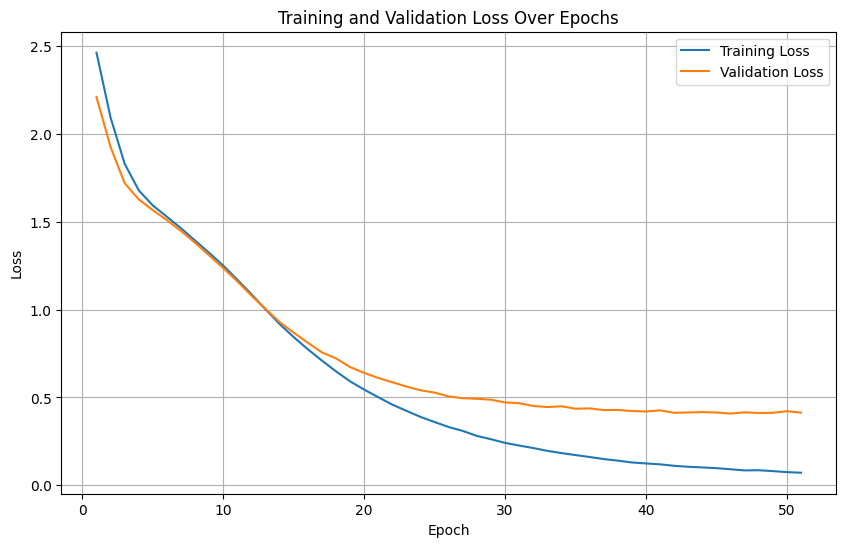

Training complete. Best model saved as 'best_model.pth'.


In [50]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Move the model to the appropriate device
model = model.to(device)

EPOCHS = 100
PATIENCE = 5  # Stop if validation loss doesn't improve for 5 epochs
min_val_loss = float('inf')
patience_counter = 0
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0

    # Training loop
    for images, labels in tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        images = images.to(device)
        labels = labels.to(device)  # Ensure labels are on the same device

        # Forward pass
        output = model(images)  # (batch_size, sequence_length, num_classes)
        output = output.permute(0, 2, 1)  # Change to (batch_size, num_classes, sequence_length)

        # Compute loss
        loss = criterion(output, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(dataloader_train)
    train_loss_values.append(epoch_train_loss)

    # Validation loop
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(dataloader_val, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            output = output.permute(0, 2, 1)

            # Compute loss
            loss = criterion(output, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(dataloader_val)
    val_loss_values.append(epoch_val_loss)

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Early stopping logic
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print(f"Validation loss improved. Model saved.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("Early stopping triggered. Training stopped.")
        break

# Plot the loss graph for training and validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label="Training Loss")
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

print("Training complete. Best model saved as 'best_model.pth'.")


# Evaluate Model

In [66]:
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model = model.to(device)
model.eval()  # Mettre le modèle en mode évaluation.



CRNNWithLSTM(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activati

In [67]:
nbtot = 0
nb_good = 0

# Pour le calcul de l'accuracy par caractère
total_characters = 0
correct_characters = 0

sequence_accuracies = []
for images, labels in dataloader_test:
    # Obtenir les prédictions du modèle
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)  # Output shape: (batch_size, sequence_length, num_classes)
    predicted_labels = output.argmax(dim=2)  # Shape: (batch_size, sequence_length)

    # Comparer les prédictions avec les étiquettes de vérité terrain
    for i in range(len(predicted_labels)):
        predicted_text = "".join([idx_to_char[idx] for idx in predicted_labels[i].detach().cpu().numpy()])
        ground_truth = "".join([idx_to_char[idx] for idx in labels[i].detach().cpu().numpy()])

        # Calcul de l'accuracy globale (match exact)
        if ground_truth == predicted_text:
            nb_good += 1
        else :
            print(f"{ground_truth:^{40}} -- {predicted_text}")
        # Calcul de l'accuracy par caractère
        correct_characters += sum(1 for a, b in zip(predicted_text, ground_truth) if a == b)
        total_characters += len(ground_truth)

        nbtot += 1

# Calcul final des métriques
exact_match_accuracy = nb_good / nbtot if nbtot > 0 else 0
character_accuracy = correct_characters / total_characters if total_characters > 0 else 0

print(f'Exact Match Accuracy: {exact_match_accuracy:.2%}')
print(f'Character-level Accuracy: {character_accuracy:.2%}')
torch.save(model.state_dict(), f'model_lenet_lstm_char={character_accuracy:.2%}_word={exact_match_accuracy:.2%}.pth')  # Save the best model


               BH-0744-TB                -- BH0044-
                KHI-5373                 -- KHT-5373
               NAK-34-44                 -- C-59-L
               60-K2-6388                -- 50A-6898
               UWP-800-B                 -- UWF-800-B
                 NO-PDK                  -- MY-0PD
               263-AE0-10                -- 263-AEA-10
               FX-515-KX                 -- FX-515-YX
               DB-12-SWH                 -- DB-12-SVH
               KA-8734-CO                -- KA-8733-OO
              01-0-200-DB                -- 01-0-220-DB
                29-QL-38                 -- 29-DL-38
                9772-DKF                 -- 9772-KFF
               D-1721-UE                 -- D-1721-UEE
                BM-04-MP                 -- BN-04-MP
                4-5610-H                 -- 4-5600-H
                 60395                   -- 60882
                32-GJT-5                 -- 32-GT-75
                J-21156                  -

In [ ]:

# Sélectionner aléatoirement 10 images
sampled_images = []
sampled_predictions = []
sampled_ground_truths = []

for images, labels in dataloader_test:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)  # Output shape: (batch_size, sequence_length, num_classes)
    predicted_labels = output.argmax(dim=2)  # Shape: (batch_size, sequence_length)

    for i in range(len(images)):
        if len(sampled_images) < 10:  # Collecter jusqu'à 10 échantillons
            sampled_images.append(images[i].detach().cpu())
            predicted_text = "".join([idx_to_char[idx] for idx in predicted_labels[i].detach().cpu().numpy()])
            ground_truth = "".join([idx_to_char[idx] for idx in labels[i].detach().cpu().numpy()])
            sampled_predictions.append(predicted_text)
            sampled_ground_truths.append(ground_truth)
        else:
            break
    if len(sampled_images) >= 10:
        break



for i,image in enumerate(sampled_images) :
    image = image.permute(1, 2, 0) *255 # Permuter pour obtenir (H, W, C)
    plt.imshow(image)
    plt.title(f"GT: {sampled_ground_truths[i]}\nPred: {sampled_predictions[i]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
from collections import Counter
letters = []

for label in Y_train :
    for char in label :
            letters.append(char)
# Compter les occurrences de chaque numéro
label_counts = Counter(letters)

# Afficher les résultats
for label, count in sorted(label_counts.items()):
    print(f"Caractère {label}: {count} occurrences")
